In [1]:
import os, sys; sys.path.append('..')
from share_src.config import read_config
from share_src.data import make_datasets

cfg = read_config()
train_dataset, test_dataset = make_datasets(cfg)


DATA:
  NAMES_OF_BAD_FILES: ['23EF07CA2AD4829E5A3DC550DDF212BE4DF432357587117B8790BF98BDB04EF52277040A3F9FB30FFFB875701FFFF0FD_202102230745.xlsx', '490175DD47C1E53DE74F180C750AA30055974E0FEFDF45C5B52C8ADC028C5B7EEC0C441B7C1869130D1B194AD47E4EDD_202103181245.xlsx']
  OVERLAP_LEN: 10
  PATH: ../data/medical_dataset/2nd_version_data
  PREDICT_MAGNITUDE: False
  PROPOFOL_ID: 5
  SOURCE_LEN: 20
  TARGET_LEN: 20
  TEST_PERCENT: 0.2
MODEL:
  ACTIVATION: gelu
  DEC_IN: 11
  DIM_OUT: 1
  DROPOUT: 0.05
  D_FF: 2048
  D_LAYERS: 1
  D_MODEL: 512
  ENC_IN: 11
  E_LAYERS: 2
  FACTOR: 1
  MOV_AVG: 11
  N_HEADS: 8
  POS_ENC_N: 2
SYSTEM:
  SEED: 2022
TEST:
  PREDICTIONS_TO_FILES: True
  SAVE_PATH: results
TRAIN:
  BATCH: 512
  CRITERION: MSE
  DILATE_GAMMA: 0.0001
  EPOCHS: 10
  LR: 0.0001
  USE_ALL_DATA: True
Total number of files read: 628
Number of correct dataframes: 605
TRAIN FILES: 484
TEST FILES: 121
 


Next part copyed directly from main.py

In [2]:
import torch
import numpy as np
from tqdm.notebook import tqdm
from data.synthetic_dataset import create_synthetic_dataset, SyntheticDataset
from models.seq2seq import EncoderRNN, DecoderRNN, Net_GRU
from loss.dilate_loss import DilateLoss
from torch.utils.data import DataLoader
import random
from tslearn.metrics import dtw, dtw_path
import matplotlib.pyplot as plt
import warnings
import warnings; warnings.simplefilter('ignore')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# I set random seeds in data.py
# random.seed(cfg.SYSTEM.SEED)
print(device)

/home/ivan/miniconda3/envs/rl-dev/lib/python3.9/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


cuda:0


In [25]:
alpha=0.5

In [ ]:
# parameters
# batch_size = 100
# N = 500
N_input = cfg.DATA.SOURCE_LEN
N_output = cfg.DATA.TARGET_LEN  
sigma = 0.01
alpha=0.5
gamma = cfg.TRAIN.DILATE_GAMMA

def train_model(net,loss_type, learning_rate, epochs=1000, gamma = 0.001,
                print_every=50,eval_every=50, verbose=1, Lambda=1, alpha=0.5):
    
    optimizer = torch.optim.Adam(net.parameters(),lr=learning_rate)
    criterion_mse = torch.nn.MSELoss()
    criterion_dilate = DilateLoss(alpha, gamma, device)
    
    losses = []
    for epoch in tqdm(range(epochs)): 
        pbar = tqdm(enumerate(trainloader, 0), 
            total=len(trainloader), leave=False)
        for i, data in pbar:
            inputs, target, _ = data
            inputs = torch.tensor(inputs, dtype=torch.float32).to(device)
            target = torch.tensor(target, dtype=torch.float32).to(device)

            # Remove positional data
            inputs = inputs[:,:,:-2]
            target = target[:,cfg.DATA.OVERLAP_LEN:,:-2]

            batch_size, N_output = target.shape[0:2]                     

            # forward + backward + optimize
            outputs = net(inputs)
            # loss_mse,loss_shape,loss_temporal = torch.tensor(0),torch.tensor(0),torch.tensor(0)
            
            # if (loss_type=='mse'):
            #     loss_mse = criterion(target,outputs)
            #     loss = loss_mse                   
 
            if (loss_type=='dilate'):    
                tgt5 = target[:,:,cfg.DATA.PROPOFOL_ID].unsqueeze(-1)
                out5 = outputs[:,:,cfg.DATA.PROPOFOL_ID].unsqueeze(-1)
                loss = criterion_dilate(tgt5, out5)
                # loss, loss_shape, loss_temporal = dilate_loss(tgt5, out5,
                # alpha, gamma, device)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses += [loss.item()]
            pbar.set_description('loss: {:.4f}'.format(loss.item()))
    
    model = net
    return model, losses
    # if(verbose):
    #     if (epoch % print_every == 0):
    #         print('epoch ', epoch, ' loss ',loss.item(),' loss shape ',loss_shape.item(),' loss temporal ',loss_temporal.item())
    #         eval_model(net,testloader, gamma,verbose=1)

trainloader = DataLoader(train_dataset, 
    batch_size=cfg.TRAIN.BATCH, shuffle=True, drop_last=True)

encoder = EncoderRNN(
    input_size=cfg.MODEL.ENC_IN, 
    hidden_size=128, 
    num_grulstm_layers=1, 
    batch_size=cfg.TRAIN.BATCH).to(device)
decoder = DecoderRNN(
    input_size=cfg.MODEL.ENC_IN, 
    hidden_size=128, 
    num_grulstm_layers=1,
    fc_units=16, 
    output_size=cfg.MODEL.ENC_IN).to(device)
net_gru_dilate = Net_GRU(encoder,decoder, N_output, device).to(device)

trained_model, losses = train_model(
    net_gru_dilate,
    loss_type='dilate',
    learning_rate=cfg.TRAIN.LR,
    epochs=cfg.TRAIN.EPOCHS, 
    gamma=gamma, 
    print_every=50, 
    eval_every=50,
    verbose=1)


In [ ]:
print(len(losses))
plt.plot(losses)

In [38]:
def eval_model(net, loader, alpha, gamma, device,verbose=1):   
    criterion_mse = torch.nn.MSELoss()
    criterion_dilate = DilateLoss(alpha, gamma, device)

    test_metrics = {
        'mse_loss':[],
        'dilate_loss':[],
    }
    
    collected_data = {
        'source':[],
        'target':[],
        'output':[],
        'seq_id':[],
    }

    for i, data in enumerate(loader, 0):
        # get the inputs
        inputs, target, seq_id = data
        inputs = torch.tensor(inputs, dtype=torch.float32).to(device)
        target = torch.tensor(target, dtype=torch.float32).to(device)
        batch_size, N_output = target.shape[0:2]

        # Remove positional data
        inputs = inputs[:,:,:-2]
        target = target[:,cfg.DATA.OVERLAP_LEN:,:-2]

        outputs = net(inputs)
        # MSE    
        tgt5 = target[:,:,cfg.DATA.PROPOFOL_ID].unsqueeze(-1)
        out5 = outputs[:,:,cfg.DATA.PROPOFOL_ID].unsqueeze(-1)
        loss_mse = criterion_mse(tgt5, out5)
        loss_dilate = criterion_dilate(tgt5, out5)
         
        # save statistics
        test_metrics['mse_loss'].append(loss_mse.item())
        test_metrics['dilate_loss'].append(loss_dilate.item())

        # collect data 
        collected_data['source'] += [inputs.detach().cpu()]
        collected_data['target'] += [tgt5.detach().cpu()]
        collected_data['output'] += [out5.detach().cpu()]
        collected_data['seq_id'] += [seq_id]

    print('Eval MSE    = ', np.array(test_metrics['mse_loss']).mean())
    print('Eval DILATE = ', np.array(test_metrics['dilate_loss']).mean())
    return test_metrics, collected_data

testloader = DataLoader(test_dataset, 
    batch_size=cfg.TRAIN.BATCH, shuffle=False, drop_last=True)

test_metrics, collected_data = eval_model(trained_model, testloader, 
    alpha, gamma, device)

Eval MSE    =  0.14261385932002427
Eval DILATE =  1.8204563231963031


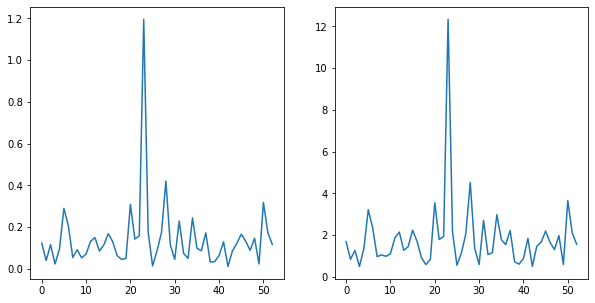

In [48]:
fig,ax = plt.subplots(1,2, figsize=(10,5))
ax[0].plot(test_metrics['mse_loss'])
ax[1].plot(test_metrics['dilate_loss'])

In [98]:
seq_id = torch.cat(collected_data['seq_id'])
# print(seq_id.shape)
target = torch.cat(collected_data['target'])
output = torch.cat(collected_data['output'])
# print(target.shape, output.shape)

criterion_mse = torch.nn.MSELoss()
criterion_dilate = DilateLoss(
    gamma=cfg.TRAIN.DILATE_GAMMA)

dilate_losses = []
mse_losses = []

for u_id in torch.unique(seq_id):
    cond = seq_id == u_id

    curr_targets = target[cond]
    curr_outputs = output[cond]

    # target_signal = []
    # output_signal = []
    target_signal = curr_targets[0,:,0].tolist()
    output_signal = curr_outputs[0,:,0].tolist()
    for bs in range(1,curr_targets.shape[0]):
        tgt_value = curr_targets[bs,0,0].item()
        out_value = curr_outputs[bs,0,0].item()
        # out_value = curr_outputs[bs].mean().item()

        target_signal += [tgt_value]
        output_signal += [out_value]
   
    output_signal = torch.tensor(output_signal).unsqueeze(-1).unsqueeze(0)
    target_signal = torch.tensor(target_signal).unsqueeze(-1).unsqueeze(0)

    mse_loss = criterion_mse(target_signal, output_signal).item()
    dilate_loss = criterion_dilate(target_signal, output_signal).item()

    dilate_losses += [dilate_loss]
    mse_losses += [mse_loss]
    # break



In [99]:
print('DILATE loss: ',np.mean(dilate_losses))
print('MSE loss: ',np.mean(mse_losses))

DILATE loss:  7.841023604409034
MSE loss:  0.08177154319274764


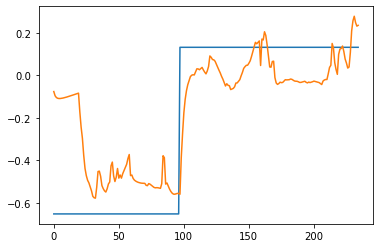

In [100]:
plt.plot(target_signal.squeeze())
plt.plot(output_signal.squeeze())